<a href="https://colab.research.google.com/github/philipp-lampert/mymandible/blob/main/data_science/02_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the data exploration and visualization notebook

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's first import the processed dataframe from GitHub.

In [2]:
local_directory = "/root/mymandible"
%cd

if os.path.exists(local_directory):
  os.chdir(local_directory)
  ! git pull
  %cd data_science/data

else:
  ! git clone https://github.com/philipp-lampert/mymandible
  %cd mymandible/data_science/data

df = pd.read_parquet('processed_data.parquet')

/root
Cloning into 'mymandible'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 210 (delta 46), reused 17 (delta 17), pack-reused 140
Receiving objects: 100% (210/210), 1.36 MiB | 9.76 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/root/mymandible/data_science/data


We will start by creating some graphs to get a sense of what our patient collective looks like.

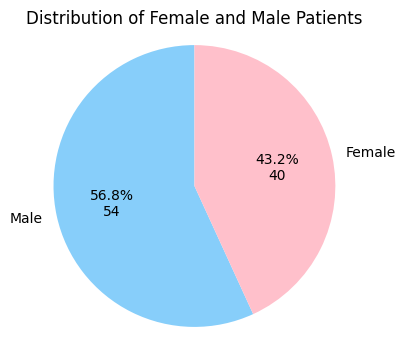

In [3]:
female_count = df['sex_female'].sum()
male_count = len(df) - female_count

labels = ['Male', 'Female']
sizes = [male_count, female_count, ]
colors = ['lightskyblue', 'pink']

# Calculate total count
total_count = sum(sizes)

# Create a pie chart with both percentage and absolute number
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct=lambda p: f'{p:.1f}%\n{int(total_count * p / 100)}', startangle=90)
plt.title('Distribution of Female and Male Patients')
plt.axis('equal')
plt.show()

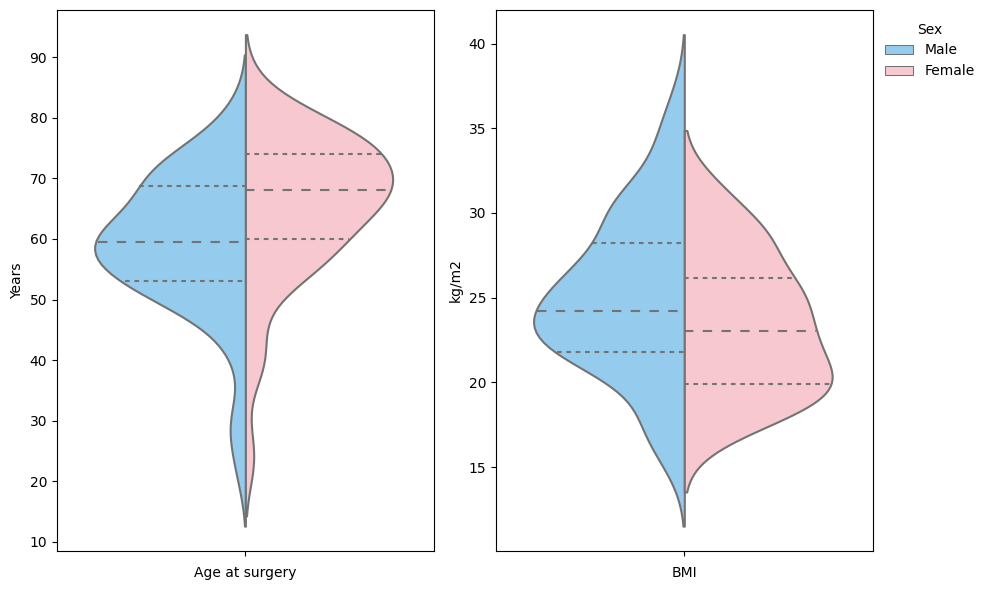

In [4]:
df['all'] = ''

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)

bw = 0.4

sns.violinplot(x=df['all'], y=df['age_surgery_years'].astype('int'), palette=colors, hue=df['sex_female'], split = True, bw=bw, inner='quart')
plt.legend([], frameon=False)

plt.xlabel('Age at surgery')
plt.ylabel('Years')
plt.title('')

plt.subplot(1, 2, 2)
ax = sns.violinplot(x=df['all'], y=df['bmi'].astype('float'), hue=df['sex_female'], palette=colors, split=True, bw=bw, inner='quart')

handles, labels = ax.get_legend_handles_labels()
labels = ["Male", "Female"]
ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(1, 1), title = 'Sex', frameon=False)

plt.xlabel('BMI')
plt.ylabel('kg/m2')
plt.title('')

plt.tight_layout()
plt.show()

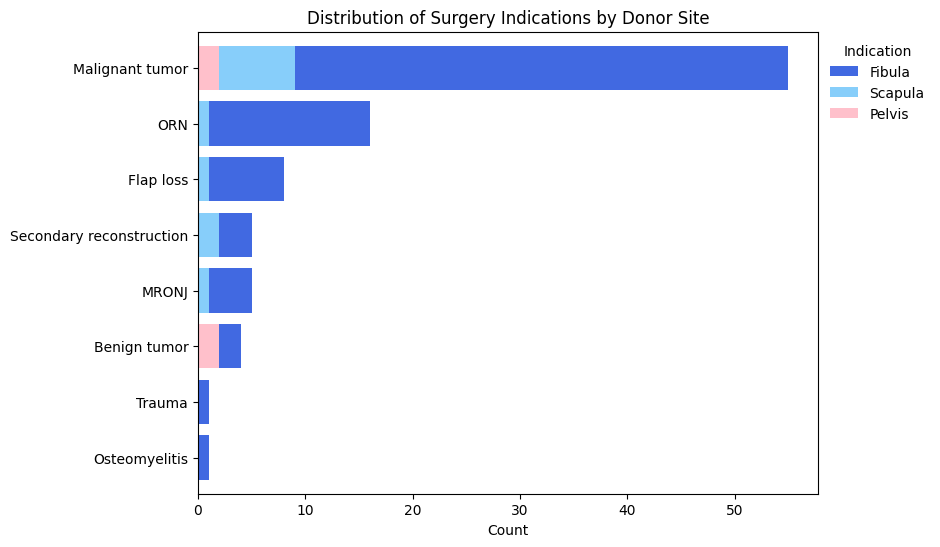

In [5]:
# Count the occurrences of 'indication' for each 'flap_donor_site'
indication_counts_by_site = df.groupby('indication')['flap_donor_site'].value_counts().unstack()

# Calculate the total counts for each 'indication'
indication_counts_by_site['total'] = indication_counts_by_site.sum(axis=1)

# Sort the 'indication_counts_by_site' DataFrame by 'total' in ascending order
indication_counts_by_site = indication_counts_by_site.sort_values(by='total', ascending=True).drop('total', axis=1)

# Define a custom order for 'flap_donor_site' columns
flap_donor_site_order = ['pelvis', 'scapula', 'fibula']

# Use the 'reorder_levels' function to reorder the 'flap_donor_site' columns
indication_counts_by_site = indication_counts_by_site[flap_donor_site_order]

# Define a dictionary to rename the 'indication' values
labels = {
    'malignant_tumor': 'Malignant tumor',
    'benign_tumor': 'Benign tumor',
    'osteoradionecrosis': 'ORN',
    'secondary_reconstruction': 'Secondary reconstruction',
    'flap_loss': 'Flap loss',
    'medication_related_osteonecrosis': 'MRONJ',
    'osteomyelitis': 'Osteomyelitis',
    'trauma': 'Trauma'
}

colors = ['pink', 'lightskyblue', 'royalblue']

# Use the 'replace' function to rename the 'indication' values
indication_counts_by_site.index = indication_counts_by_site.index.to_series().replace(labels)

# Create a stacked bar chart
ax = indication_counts_by_site.plot(kind='barh', stacked=True, figsize=(8, 6), color=colors, width=0.8)

# Set labels and title
plt.xlabel('Count')
plt.ylabel('')
plt.title('Distribution of Surgery Indications by Donor Site')

# Customize the legend order
legend_order = {
    "pelvis": 0,
    "scapula": 1,
    "fibula": 2,
}

handles, labels = ax.get_legend_handles_labels()
labels = ["Pelvis", "Scapula", "Fibula"]
order = [2, 1, 0]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc="upper left", bbox_to_anchor=(1, 1), title = 'Indication', frameon=False)

plt.show()


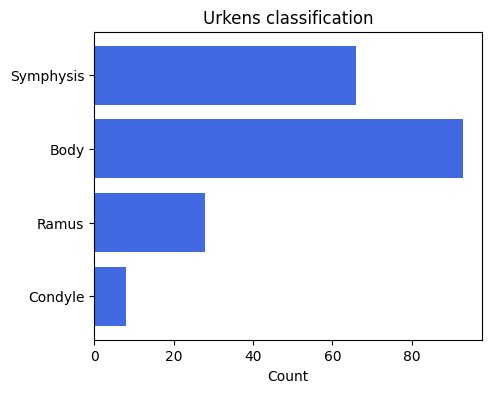

In [6]:
value_counts = {}

for column in df.columns:
    if "urkens_classification___" in column:
        variable_option = column.replace('urkens_classification___', '')
        value_counts[variable_option] = df[column].sum()

urkens_classification_df = pd.DataFrame(list(value_counts.items()), columns=['urkens_classification', 'count'])

labels = {
    'c': 'Condyle',
    'r': 'Ramus',
    'b': 'Body',
    's': 'Symphysis'
}
urkens_classification_df['urkens_classification'] = urkens_classification_df['urkens_classification'].map(labels)

colors = ['lightskyblue' if value == 'None' else 'royalblue' for value in urkens_classification_df['urkens_classification']]

# Create a bar chart
plt.figure(figsize=(5, 4))
bars = plt.barh(urkens_classification_df['urkens_classification'], urkens_classification_df['count'], color=colors)
plt.title('Urkens classification')
plt.xlabel('Count')
plt.ylabel('')

plt.show()

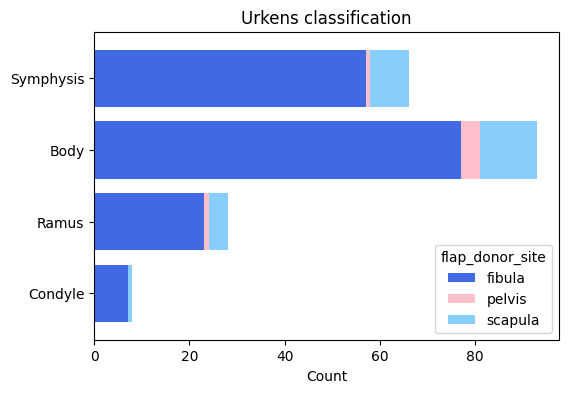

In [7]:
classification_columns = [col for col in df.columns if col.startswith("urkens_classification___")]
classification_counts_by_site = df.groupby('flap_donor_site')[classification_columns].sum()

classification_counts_by_site = classification_counts_by_site[classification_counts_by_site.sum().index].T

labels = {
    'urkens_classification___c': 'Condyle',
    'urkens_classification___r': 'Ramus',
    'urkens_classification___b': 'Body',
    'urkens_classification___s': 'Symphysis'
}

# Use the 'replace' function to rename the 'indication' values
classification_counts_by_site.index = classification_counts_by_site.index.to_series().replace(labels)

# Create a stacked bar chart
ax = classification_counts_by_site.plot(kind='barh', stacked=True, figsize=(6, 4), color=['royalblue', 'pink', 'lightskyblue'], width=0.8)

# Create a bar chart
plt.title('Urkens classification')
plt.xlabel('Count')
plt.ylabel('')

plt.show()

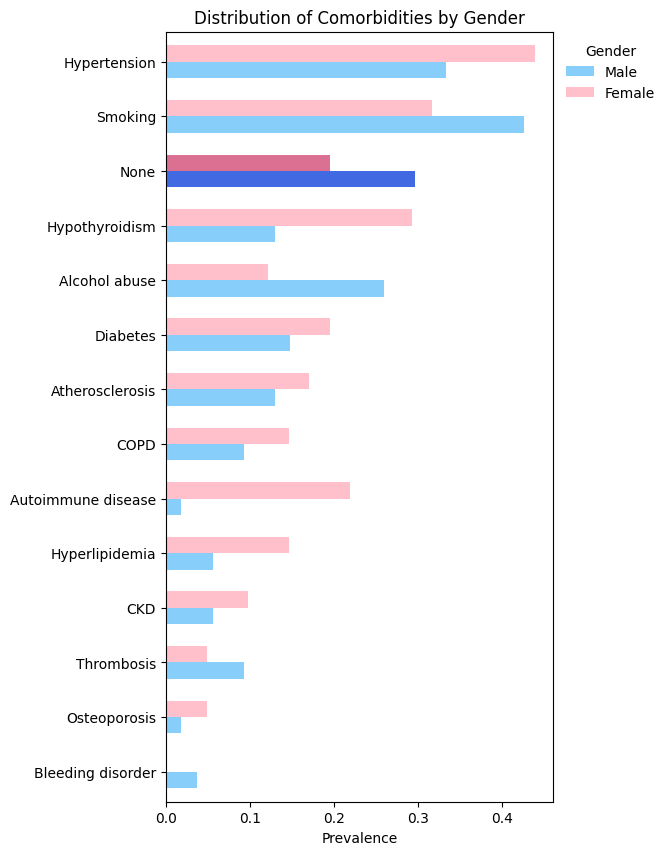

In [8]:
comorbidity_columns = [col for col in df.columns if col.startswith("comorbidity___")]
comorbidity_counts_by_gender = df.groupby('sex_female')[comorbidity_columns].mean()

comorbidity_counts_by_gender = comorbidity_counts_by_gender[comorbidity_counts_by_gender.sum().sort_values(ascending=True).index].T

comorbidity_labels = {
    'comorbidity___smoking': 'Smoking',
    'comorbidity___hypertension': 'Hypertension',
    'comorbidity___none': 'None',
    'comorbidity___alcohol': 'Alcohol abuse',
    'comorbidity___diabetes': 'Diabetes',
    'comorbidity___hypothyroidism': 'Hypothyroidism',
    'comorbidity___copd': 'COPD',
    'comorbidity___atherosclerosis': 'Atherosclerosis',
    'comorbidity___hyperlipidemia': 'Hyperlipidemia',
    'comorbidity___autoimmune_disease': 'Autoimmune disease',
    'comorbidity___osteoporosis': 'Osteoporosis',
    'comorbidity___thrombosis': 'Thrombosis',
    'comorbidity___chronic_kidney_disease': 'CKD',
    'comorbidity___bleeding_disorder': 'Bleeding disorder'
}

comorbidity_counts_by_gender = comorbidity_counts_by_gender.rename(columns={True: 'Female', False: 'Male'})
comorbidity_counts_by_gender.index = comorbidity_counts_by_gender.index.map(comorbidity_labels)

def setcolors(ax, name="None", colors=['royalblue', 'palevioletred']):
    # get labels
    ytl = ax.get_yticklabels()
    numlabels = len(ytl)

    # find the index of the given named label
    for i, t in enumerate(ytl):
        if t.get_text() == name:
            break

    # get the matplotlib rectangle objects representing the bars
    # (note this relies on nothing else having been added to the plot)
    rects = ax.get_children()[0:2 * numlabels]
    nrects = [rects[i], rects[numlabels + i]]

    # loop over the two bars for the given named label and change the colours
    for rect, color in zip(nrects, colors):
        rect.set_color(color)
        rect.set_edgecolor("none")

bars = comorbidity_counts_by_gender.plot(kind='barh', stacked=False, figsize=(5, 10), color=["lightskyblue", "pink"], width=0.6)

plt.title('Distribution of Comorbidities by Gender')
plt.xlabel('Prevalence')
plt.ylabel('')
bars.legend(title='Gender', loc="upper left", bbox_to_anchor=(1, 1), frameon=False)

setcolors(bars)

plt.show()

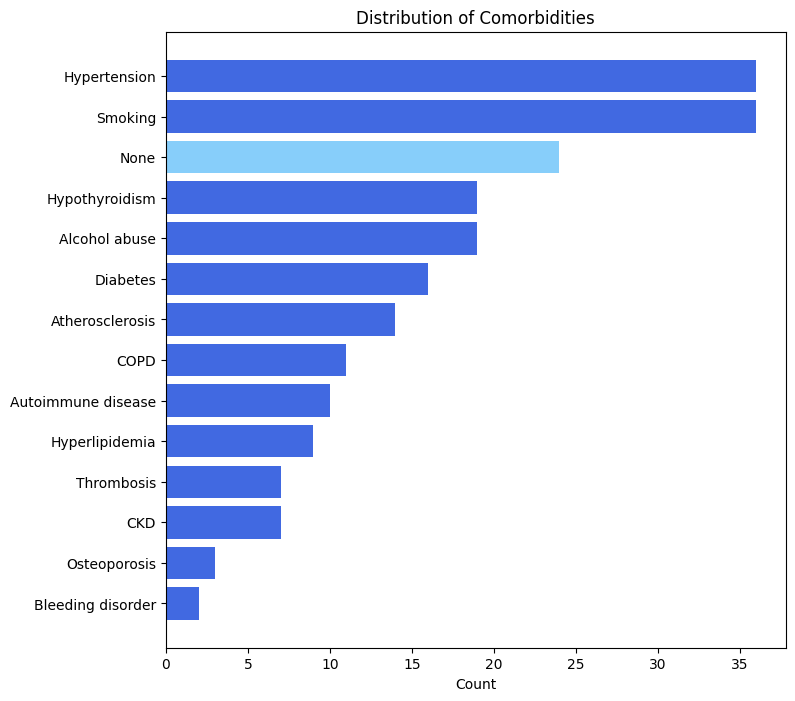

In [9]:
comorbidity_counts = {}

# Calculate counts for comorbidity columns
for column in df.columns:
    if "comorbidity___" in column:
        comorbidity_option = column.replace('comorbidity___', '')
        comorbidity_counts[comorbidity_option] = df[column].sum()

comorbidity_df = pd.DataFrame(list(comorbidity_counts.items()), columns=['Comorbidity', 'Count'])
comorbidity_df = comorbidity_df.sort_values(by='Count', ascending=True)

labels = {
    'smoking': 'Smoking',
    'hypertension': 'Hypertension',
    'none': 'None',
    'alcohol': 'Alcohol abuse',
    'diabetes': 'Diabetes',
    'hypothyroidism': 'Hypothyroidism',
    'copd': 'COPD',
    'atherosclerosis': 'Atherosclerosis',
    'hyperlipidemia': 'Hyperlipidemia',
    'autoimmune_disease': 'Autoimmune disease',
    'osteoporosis': 'Osteoporosis',
    'thrombosis': 'Thrombosis',
    'chronic_kidney_disease': 'CKD',
    'bleeding_disorder': 'Bleeding disorder'
}
comorbidity_df['Comorbidity'] = comorbidity_df['Comorbidity'].map(labels)

colors = ['lightskyblue' if comorbidity == 'None' else 'royalblue' for comorbidity in comorbidity_df['Comorbidity']]

# Create a bar chart
plt.figure(figsize=(8, 8))
bars = plt.barh(comorbidity_df['Comorbidity'], comorbidity_df['Count'], color=colors)
plt.title('Distribution of Comorbidities')
plt.xlabel('Count')
plt.ylabel('')

plt.show()

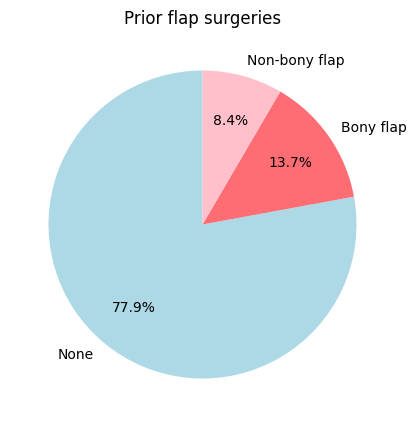

In [10]:
flap_counts = df['prior_flap'].value_counts()

sizes = flap_counts.values
colors = ['lightblue', '#fe6d73', 'pink']

labels = {
    'none': 'None',
    'bony': 'Bony flap',
    'non_bony': 'Non-bony flap',
}

flap_counts = flap_counts.rename(labels)
labels = flap_counts.index

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.7)
plt.title('Prior flap surgeries')
plt.show()

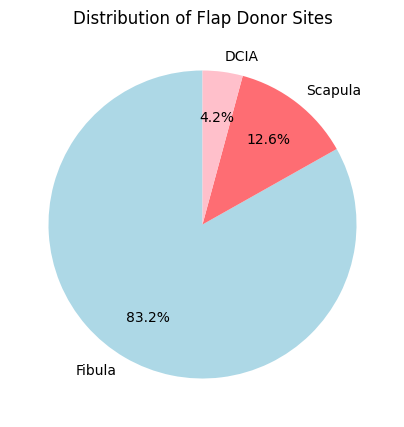

In [12]:
value_counts = df['flap_donor_site'].value_counts()

labels = {
    'fibula': 'Fibula',
    'scapula': 'Scapula',
    'pelvis': 'DCIA',
}

value_counts = value_counts.rename(labels)
labels = value_counts.index

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(value_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.7)

plt.title('Distribution of Flap Donor Sites')
plt.show()

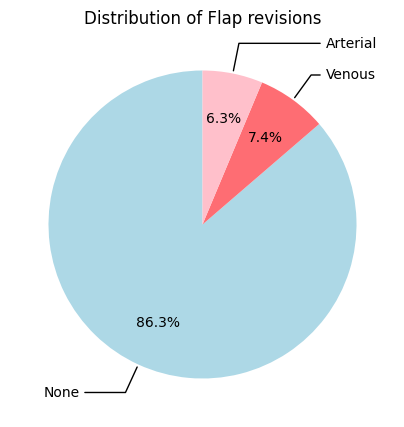

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Your existing code for pie chart
value_counts = df['flap_revision'].value_counts()
labels = {
    'none': 'None',
    'arterial': 'Arterial',
    'venous': 'Venous',
}
value_counts = value_counts.rename(labels)
labels = value_counts.index

plt.figure(figsize=(5, 5))
wedges, texts, autotexts = plt.pie(value_counts, autopct='%1.1f%%', startangle=90, pctdistance=0.7, colors=colors)

# Customize the labels outside the pie
kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2.0 + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})

    # Adjust the label position for better visibility
    xtext = 0.8 * np.sign(x)
    ytext = 1.2 * y
    plt.annotate(labels[i], (x, y), xytext=(xtext, ytext), horizontalalignment=horizontalalignment, **kw)

plt.title('Distribution of Flap revisions')
plt.show()


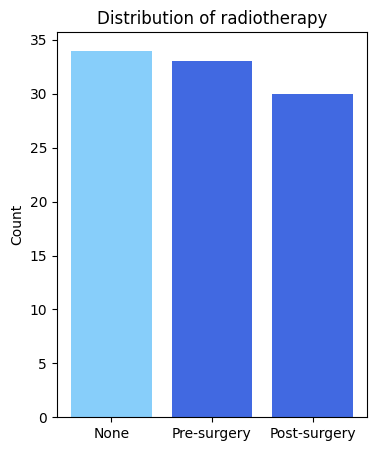

In [14]:
radiotherapy_counts = {}

# Calculate counts for radiotherapy columns
for column in df.columns:
    if "radiotherapy___" in column:
        radiotherapy_option = column.replace('radiotherapy___', '')
        radiotherapy_counts[radiotherapy_option] = df[column].sum()

radiotherapy_df = pd.DataFrame(list(radiotherapy_counts.items()), columns=['radiotherapy', 'count'])

labels = {
    'none': 'None',
    'pre_surgery': 'Pre-surgery',
    'post_surgery': 'Post-surgery'
}
radiotherapy_df['radiotherapy'] = radiotherapy_df['radiotherapy'].map(labels)
colors = ['lightskyblue' if radiotherapy == 'None' else 'royalblue' for radiotherapy in radiotherapy_df['radiotherapy']]

# Create a bar chart
plt.figure(figsize=(4, 5))
bars = plt.bar(radiotherapy_df['radiotherapy'], radiotherapy_df['count'], color=colors)
plt.title('Distribution of radiotherapy')
plt.xlabel('')
plt.ylabel('Count')

plt.show()

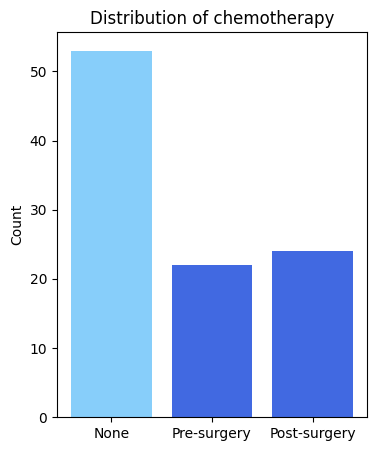

In [15]:
chemotherapy_counts = {}

for column in df.columns:
    if "chemotherapy___" in column:
        chemotherapy_option = column.replace('chemotherapy___', '')
        chemotherapy_counts[chemotherapy_option] = df[column].sum()

chemotherapy_df = pd.DataFrame(list(chemotherapy_counts.items()), columns=['chemotherapy', 'Count'])

labels = {
    'none': 'None',
    'pre_surgery': 'Pre-surgery',
    'post_surgery': 'Post-surgery'
}
chemotherapy_df['chemotherapy'] = chemotherapy_df['chemotherapy'].map(labels)

colors = ['lightskyblue' if chemotherapy == 'None' else 'royalblue' for chemotherapy in chemotherapy_df['chemotherapy']]

# Create a bar chart
plt.figure(figsize=(4, 5))
bars = plt.bar(chemotherapy_df['chemotherapy'], chemotherapy_df['Count'], color=colors)
plt.title('Distribution of chemotherapy')
plt.xlabel('')
plt.ylabel('Count')

plt.show()


In [270]:
# Plot for plate type and plate thickness

In [271]:
# Plot for TMJ replacement type

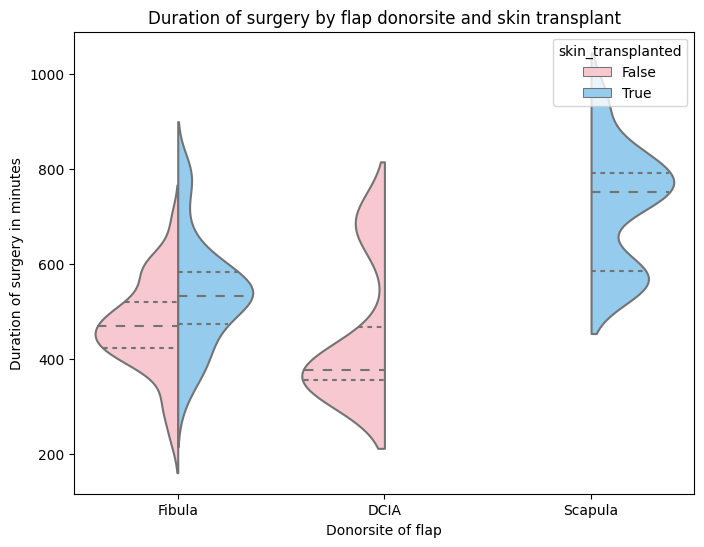

In [16]:
plt.figure(figsize=(8, 6))

colors = ['pink', 'lightskyblue']

bw = 0.4

labels = {
    'fibula': 'Fibula',
    'pelvis': 'DCIA',
    'scapula': 'Scapula'
}

df['flap_donor_site'] = df['flap_donor_site'].map(labels)

sns.violinplot(x=df['flap_donor_site'], y=df['surgery_duration_min'].astype('int'), hue=df['skin_transplanted'].fillna(False).astype('bool'), split=True, palette=colors, bw=bw, inner='quart')

plt.xlabel('Donorsite of flap')
plt.ylabel('Duration of surgery in minutes')
plt.title('Duration of surgery by flap donorsite and skin transplant')

plt.show()

In [273]:
df.columns.values

array(['sex_female', 'indication', 'comorbidity___none',
       'comorbidity___smoking', 'comorbidity___alcohol',
       'comorbidity___copd', 'comorbidity___hypertension',
       'comorbidity___diabetes', 'comorbidity___atherosclerosis',
       'comorbidity___hyperlipidemia', 'comorbidity___osteoporosis',
       'comorbidity___hypothyroidism',
       'comorbidity___chronic_kidney_disease', 'comorbidity___thrombosis',
       'comorbidity___bleeding_disorder',
       'comorbidity___autoimmune_disease', 'which_autoimmune_disease',
       'which_bleeding_disorder', 'prior_flap', 'age_surgery_years',
       'flap_donor_site', 'flap_revision', 'days_to_flap_revision',
       'radiotherapy___none', 'radiotherapy___pre_surgery',
       'radiotherapy___post_surgery', 'chemotherapy___none',
       'chemotherapy___pre_surgery', 'chemotherapy___post_surgery',
       'plate_type', 'long_plate_thickness', 'urkens_classification___c',
       'urkens_classification___r', 'urkens_classification___b',
